<a href="https://colab.research.google.com/github/Uros-Males/Minimization_Problem_On_Identical_Machines_Analysis/blob/main/NEWNEW_MIXED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time
import keras


df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')



df = df[df['n/m']==2]

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = [ 'index', 'inst.name','type', 'CPLEXStatus'] #cple
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
names = ['indeks', 'n', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', 'av.length', 'std.dev', 'median', 'range', 'min', 'max', 'k']

In [2]:
y_new = []
cnt0=0
cnt1=0
cnt2=0
cnt3=0
for val in y:
  if(val<10):
    y_new.append(0)
    cnt0+=1
  elif(10 <= val and val<1000):
    y_new.append(1)
    cnt1+=1
  else:
    y_new.append(2)
    cnt2+=1

cnt = 0
if(cnt0>0):
  cnt+=1
if(cnt1>0):
  cnt+=1
if(cnt2>0):
  cnt+=1
if(cnt3>0):
  cnt+=1

shuffled['y_new'] = y_new
y_encoded = shuffled.loc[:,'y_new']
y_new = np.array(y_new)

In [3]:
names = [ 'av.length', 'n', 'std.dev', 'k', 'm', 'max']
X_modified = X.drop([   'n/m', 'indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n','median', 'min', 'range'], axis = 1)
print(X_modified.head())
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(random_state=0)
X_modified, y_encoded = oversample.fit_resample(X_modified, y_encoded)


     n    m   av.length     std.dev  max    k             y
0  140   70  343.121429  121.472290  556  113     10.026574
1   40   20   65.550003   22.500086  100   30      0.920937
2  200  100   57.825001   22.578833  100   75     26.029591
3  180   90  467.405548  156.015503  717  148      9.815632
4  140   70  547.578552  137.977631  917  121  99999.000000


In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

l_encode = LabelEncoder()
l_encode.fit(y_encoded)
y_encoded = l_encode.transform(y_encoded)
y_encoded = to_categorical(y_encoded)
y_encoded

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [5]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()


X_train, X_test, y_train, y_test = train_test_split(X_modified, y_encoded, random_state=0, train_size = 0.83)
print(X_train.shape[0])
print(X_test.shape[0])

X_train = X_train.drop(['y', 'k', 'm'], axis = 1)

X_train = sc.fit_transform(X_train)
X_test_copy = X_test
print(X_test_copy.head())
X_test = X_test.drop(['y', 'k', 'm'], axis = 1)
X_test = sc.transform(X_test)

1267
260
        n    m   av.length     std.dev   max    k             y
1362  180   90  706.877808  175.294418  1104  154  99999.000000
511   100   50   59.770000   22.366035   100   55      8.042485
9     200  100   45.939999   28.773180    98   81      2.639991
393    20   10   48.349998   15.812304    79   17      0.146769
471    80   40   56.049999   23.062872    99   45      6.669239


In [6]:

from keras.models import Sequential
from keras.layers import Dense, Dropout

classifier = Sequential()
classifier.add(Dense(8, input_dim = X_modified.shape[1]-3, activation='relu'))

classifier.add(Dense(12, activation = 'relu'))
classifier.add(Dropout(0.125))

#classifier.add(Dense(32, activation = 'relu'))

#classifier.add(Dense(32, activation = 'relu'))
#classifier.add(Dense(32, activation = 'relu'))
#classifier.add(Dense(16, activation = 'relu'))

#classifier.add(Dense(16, activation='relu'))

#classifier.add(Dense(8, activation='relu'))

#classifier.add(Dense(12, activation='relu'))

classifier.add(Dense(cnt, activation = 'softmax'))
classifier.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 12)                108       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 39        
                                                                 
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 25, 
                                        restore_best_weights = True)
  
history = classifier.fit(X_train, y_train, batch_size = 64, 
                    epochs = 350, shuffle = True)

Epoch 1/350
20/20 [==============================] - 1s 4ms/step - loss: 1.1855 - accuracy: 0.3047
Epoch 2/350
20/20 [==============================] - 0s 4ms/step - loss: 1.1332 - accuracy: 0.3481
Epoch 3/350
20/20 [==============================] - 0s 6ms/step - loss: 1.0860 - accuracy: 0.4033
Epoch 4/350
20/20 [==============================] - 0s 4ms/step - loss: 1.0528 - accuracy: 0.4586
Epoch 5/350
20/20 [==============================] - 0s 4ms/step - loss: 1.0250 - accuracy: 0.4957
Epoch 6/350
20/20 [==============================] - 0s 4ms/step - loss: 0.9888 - accuracy: 0.5588
Epoch 7/350
20/20 [==============================] - 0s 5ms/step - loss: 0.9698 - accuracy: 0.5462
Epoch 8/350
20/20 [==============================] - 0s 5ms/step - loss: 0.9326 - accuracy: 0.5785
Epoch 9/350
20/20 [==============================] - 0s 3ms/step - loss: 0.9140 - accuracy: 0.5809
Epoch 10/350
20/20 [==============================] - 0s 7ms/step - loss: 0.8699 - accuracy: 0.6062
Epoch 11/

accuracy: 93.08%


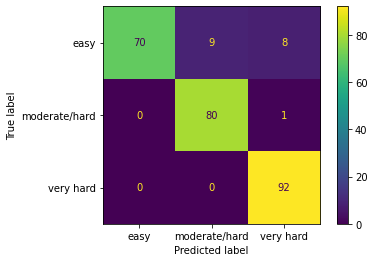

In [8]:
from keras.metrics import accuracy
pred = classifier.predict(X_test)
pred_ = np.argmax(pred, axis = 1)
pred_ = l_encode.inverse_transform(pred_)

true_y = l_encode.inverse_transform(np.argmax(to_categorical(y_test), axis = 1)[:,1])
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_y, pred_, labels=[0, 1, 2])
cmd = ConfusionMatrixDisplay(cm, display_labels=['easy','moderate/hard', 'very hard'])
cmd.plot()

cnt = 0
cnt_correct = 0
for i in range(len(pred)):
  cnt += 1
  if(pred_[i] == true_y[i]):
    cnt_correct += 1
print(f'accuracy: {(cnt_correct/cnt)*100:.2f}%')

In [9]:
column_names = ['n', 'k', 'n/m', 'av.length', 'std.dev', 'y']
df_reg = pd.DataFrame(columns = column_names)
print(X_test_copy.shape[0])
print(len(pred))
for i in range(len(pred)):
  if(pred_[i] == 1):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'n/m': 2, 
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg = df_reg.append(dictionary, ignore_index = True)
#VM

260
260


In [10]:
column_names = ['n', 'k', 'm', 'std.dev', 'y']
df_reg0 = pd.DataFrame(columns = column_names)
print(X_test_copy.shape[0])
print(len(pred))
for i in range(len(pred)):
  if(pred_[i] == 0):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 
                  'm' : X_test_copy.iloc[i]['m'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg0 = df_reg0.append(dictionary, ignore_index = True)
#EASY

260
260


In [11]:
column_names = ['n', 'k', 'av.length', 'std.dev', 'y']
df_reg2 = pd.DataFrame(columns = column_names)
print(X_test_copy.shape[0])
print(len(pred))
for i in range(len(pred)):
  if(pred_[i] == 2):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg2 = df_reg2.append(dictionary, ignore_index = True)

#VHARD

260
260


In [12]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time
import keras


df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')




df = df[df['n/m']!=2]

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = [ 'index', 'inst.name','type', 'CPLEXStatus'] 
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
names = ['indeks', 'n', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', 'av.length', 'std.dev', 'median', 'range', 'min', 'max', 'k']

In [13]:
y_new = []
for val in y:
  if(val<10):
    y_new.append(0)
  elif(10 <= val and val <1000):
    y_new.append(1)
  else:
    y_new.append(2)

shuffled['y_new'] = y_new
y_encoded = shuffled.loc[:,'y_new']
y_new = np.array(y_new)
X_modified = X

In [14]:
from imblearn.over_sampling import RandomOverSampler

names =[ 'std.dev', 'n','n/m', 'max','av.length', 'm', 'k']
X_modified = X.drop([  'median', 'range',  'min','indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n'], axis = 1)
X_modified['n/m'] = X_modified['n/m']
#print(X_modified.head())

oversample = RandomOverSampler(random_state=0)
#oversample.fit(X_modified, y_encoded)
X_modified, y_encoded = oversample.fit_resample(X_modified, y_encoded)

In [15]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

l_encode = LabelEncoder()
l_encode.fit(y_encoded)
y_encoded = l_encode.transform(y_encoded)
y_encoded = to_categorical(y_encoded)
y_encoded

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [16]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y_encoded, random_state=0, train_size = 0.83)
print(X_train.shape[0])
print(X_test.shape[0])

X_train = X_train.drop(['y', 'n', 'm', 'std.dev'], axis = 1)
X_train = sc.fit_transform(X_train)
X_test_copy = X_test
print(X_test_copy.head())
X_test = X_test.drop(['y', 'n', 'm', 'std.dev'], axis = 1)
X_test = sc.transform(X_test)

11401
2336
         n   m    n/m   av.length     std.dev   max    k             y
3234    40  16   2.50   99.150002   32.385933   160   35      5.184934
4495   180  60   3.00  449.022217  154.397949   714  150    526.371094
10982   18   8   2.25  106.500000   55.454536   206   18      0.221920
9657    80  32   2.50   60.450001   25.334669   100   53      9.711271
5976   154  14  11.00  609.844177  150.485596  1017  135  99999.000000


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

classifier = Sequential()
classifier.add(Dense(16, input_dim = X_modified.shape[1]-4, activation='relu'))

classifier.add(Dropout(0.2))

classifier.add(Dense(3, activation = 'softmax'))
classifier.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                80        
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [18]:
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 25, 
                                        restore_best_weights = True)
  
history = classifier.fit(X_train, y_train, batch_size = 32, 
                    epochs = 120)

Epoch 1/120
357/357 [==============================] - 1s 2ms/step - loss: 0.6989 - accuracy: 0.7091
Epoch 2/120
357/357 [==============================] - 1s 2ms/step - loss: 0.4829 - accuracy: 0.8079
Epoch 3/120
357/357 [==============================] - 1s 2ms/step - loss: 0.4350 - accuracy: 0.8292
Epoch 4/120
357/357 [==============================] - 1s 2ms/step - loss: 0.4084 - accuracy: 0.8366
Epoch 5/120
357/357 [==============================] - 1s 2ms/step - loss: 0.3958 - accuracy: 0.8440
Epoch 6/120
357/357 [==============================] - 1s 2ms/step - loss: 0.3819 - accuracy: 0.8498
Epoch 7/120
357/357 [==============================] - 1s 2ms/step - loss: 0.3754 - accuracy: 0.8536
Epoch 8/120
357/357 [==============================] - 1s 2ms/step - loss: 0.3664 - accuracy: 0.8534
Epoch 9/120
357/357 [==============================] - 1s 2ms/step - loss: 0.3652 - accuracy: 0.8560
Epoch 10/120
357/357 [==============================] - 1s 2ms/step - loss: 0.3604 - accura

accuracy: 88.53%


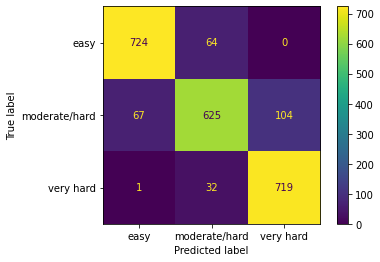

In [19]:
from keras.metrics import accuracy
pred = classifier.predict(X_test)
pred_ = np.argmax(pred, axis = 1)
pred_ = l_encode.inverse_transform(pred_)

true_y = l_encode.inverse_transform(np.argmax(to_categorical(y_test), axis = 1)[:,1])
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_y, pred_, labels=[0, 1, 2])
cmd = ConfusionMatrixDisplay(cm, display_labels=['easy','moderate/hard', 'very hard'])

cmd.plot()

cnt = 0
cnt_correct = 0
for i in range(len(pred)):
  cnt += 1
  if(pred_[i] == true_y[i]):
    cnt_correct += 1
print(f'accuracy: {(cnt_correct/cnt)*100:.2f}%')

In [20]:
for i in range(len(pred)):
  if(pred_[i] == 1):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'n/m': X_test_copy.iloc[i]['n/m'], 
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg = df_reg.append(dictionary, ignore_index = True)

for i in range(len(pred)):
  if(pred_[i] == 0):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 
                  'm' : X_test_copy.iloc[i]['m'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg0 = df_reg0.append(dictionary, ignore_index = True)
#EASY

for i in range(len(pred)):
  if(pred_[i] == 2):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg2 = df_reg2.append(dictionary, ignore_index = True)

#VHARD

In [21]:
print(df_reg.shape[0])
print(df_reg.head(500))

810
         n      k   n/m   av.length     std.dev          y
0    200.0   81.0  2.00   45.939999   28.773180   2.639991
1    120.0   68.0  2.00   59.224998   22.930464  11.224472
2    180.0   48.0  2.00   75.883331   15.566857  14.036451
3    140.0  119.0  2.00  332.799988  112.981964  31.155790
4    140.0  118.0  2.00  336.092865  112.169182  26.046606
..     ...    ...   ...         ...         ...        ...
495  176.0   86.0  2.75   48.477272   29.473080  37.967934
496  180.0   72.0  5.00   58.505554   23.007040  66.508308
497   54.0   46.0  4.50  134.166672   44.849751  48.309464
498  140.0   50.0  2.50   73.442856   14.530680  19.191570
499  126.0   68.0  3.00   61.674603   22.464844  28.213385

[500 rows x 6 columns]


In [22]:
print(df_reg0.head())

       n     k     m     std.dev         y
0  100.0  55.0  50.0   22.366035  8.042485
1   20.0  17.0  10.0   15.812304  0.146769
2   80.0  45.0  40.0   23.062872  6.669239
3  100.0  87.0  50.0  102.894897  3.314548
4   40.0  34.0  20.0   38.792603  1.172840


In [23]:
print(df_reg2.head())

       n      k   av.length     std.dev             y
0  180.0  154.0  706.877808  175.294418  99999.000000
1  120.0  101.0  467.700012  115.940849  99999.000000
2   80.0   57.0   99.199997   47.029049  99999.000000
3   80.0   66.0  106.937500   48.509495  99999.000000
4  120.0   89.0  101.000000   46.163391      0.703672


In [24]:
for i in range(df_reg.shape[0]):
  if(df_reg.iloc[i]['y'] >1000):
    df_reg.loc[i, 'y'] = 1001

for i in range(df_reg0.shape[0]):
  if(df_reg0.iloc[i]['y'] > 10):
    df_reg0.loc[i, 'y'] = 11

for i in range(df_reg2.shape[0]):
  if(df_reg2.iloc[i]['y'] == 99999):
    df_reg2.loc[i, 'y'] = 4510


print(df_reg['y'].max())
shuffled = df_reg.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
X_modified = X

1001.0


In [25]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
tmp = tmp.sample(frac = 1).reset_index()
print(tmp.head(60))
#y = np.log10(tmp['y']*10)+20
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)

7904
7904
    index      n      k    n/m   av.length     std.dev    y
0    6210  162.0   71.0   4.50   97.962959   21.328800  324
1    4064   44.0   38.0  11.00   53.590908   29.511780  127
2    5201  160.0   70.0   5.00   99.443748   19.852201  194
3    6469  126.0   62.0   6.00   62.365078   22.095287  373
4    2525  180.0   73.0   2.50   98.894447   20.039488   71
5    1015  176.0  109.0   2.75  102.232956   48.726254    9
6     886  180.0  119.0   2.00   97.027779   45.132622    3
7    4897  180.0   72.0   4.50   99.150002   19.391722  178
8    3903   44.0   28.0  11.00   76.954544   15.064134  121
9    7373  140.0  123.0   2.50  342.857147  124.946678  548
10    751  200.0  119.0   2.50  101.699997   49.112724    4
11   3982   54.0   51.0   4.50  136.425919   47.734165  124
12    998  108.0   46.0   2.25   75.685188   14.298976    8
13   6423  162.0  113.0   4.50  100.049385   52.371666  360
14   7824  140.0   97.0   5.00   99.942856   45.319302  750
15    597   72.0   63.0   6.00

In [26]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 4510*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(1, activation = custom_activation))
    model.compile(loss='mean_squared_error', optimizer="Adam")
    return model

In [27]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.83)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=300, batch_size=64, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/300
103/103 [==============================] - 1s 2ms/step - loss: 2146287.7500
Epoch 2/300
103/103 [==============================] - 0s 2ms/step - loss: 261271.4219
Epoch 3/300
103/103 [==============================] - 1s 6ms/step - loss: 86516.2422
Epoch 4/300
103/103 [==============================] - 1s 5ms/step - loss: 59325.4180
Epoch 5/300
103/103 [==============================] - 0s 2ms/step - loss: 50359.7266
Epoch 6/300
103/103 [==============================] - 0s 2ms/step - loss: 43814.6641
Epoch 7/300
103/103 [==============================] - 0s 2ms/step - loss: 37768.7305
Epoch 8/300
103/103 [==============================] - 0s 2ms/step - loss: 31730.6465
Epoch 9/300
103/103 [==============================] - 0s 2ms/step - loss: 28499.0020
Epoch 10/300
103/103 [==============================] - 0s 2ms/step - loss: 24790.1465
Epoch 11/300
103/103 [==============================] - 0s 2ms/step - loss: 22318.0820
Epoch 12/300
103/103 [===========================

In [28]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

21/21 [==============================] - 0s 1ms/step
r_square score:  0.9265532469115046
RMSE:


53.292772484059334

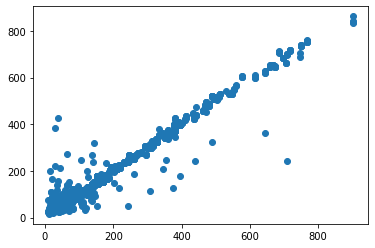

In [29]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  if(yy[i]>=10 and yy[i]<1000):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

plt.scatter(yy_temp, predd_temp)

In [30]:
shuffled = df_reg0.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
X_modified = X

In [31]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
print(tmp.head(60))
tmp = tmp.sample(frac = 1).reset_index()
#y = np.log10(tmp['y']*10)+20
tmp = tmp.dropna()
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)

3432
3432
        n     k     m    std.dev   y
0    40.0  32.0  16.0  16.090271   2
1    18.0  17.0   6.0  28.893766   0
2    18.0  16.0   3.0  25.950176   0
3    20.0  19.0   5.0  43.534622   0
4    20.0  18.0   5.0  17.910303   0
5    36.0  32.0  16.0  54.048389   1
6    44.0  30.0  16.0  21.785713   3
7    54.0  30.0  18.0  14.755259   6
8    60.0  45.0  24.0  23.251089   5
9    44.0  31.0  16.0  14.316327   4
10   18.0  18.0   2.0  52.771675   1
11   54.0  38.0  24.0  14.938553   3
12   22.0  19.0   8.0  19.110298   0
13   54.0  40.0  18.0  19.775089   8
14   18.0  16.0   8.0  12.701321   0
15  126.0  86.0  56.0  41.774616  11
16   72.0  60.0  32.0  64.198402   4
17   20.0  18.0  10.0  16.929808   0
18   22.0  20.0   8.0  18.840927   0
19   22.0  20.0   8.0  53.170414   0
20   36.0  31.0   8.0  41.549625  11
21   18.0  16.0   4.0  23.887539   0
22   54.0  39.0  12.0  29.756241   8
23   44.0  35.0  16.0  41.860203   8
24   72.0  56.0  32.0  42.463898  11
25   18.0  14.0   3.0  13.11

In [32]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 10*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(12, activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(1, activation = custom_activation))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [33]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.83)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=300, batch_size=64, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


45/45 [==============================] - 1s 2ms/step - loss: 9.2396
Epoch 2/300
45/45 [==============================] - 0s 2ms/step - loss: 7.5114
Epoch 3/300
45/45 [==============================] - 0s 2ms/step - loss: 5.8230
Epoch 4/300
45/45 [==============================] - 0s 2ms/step - loss: 4.6216
Epoch 5/300
45/45 [==============================] - 0s 2ms/step - loss: 3.9511
Epoch 6/300
45/45 [==============================] - 0s 2ms/step - loss: 3.6788
Epoch 7/300
45/45 [==============================] - 0s 2ms/step - loss: 3.4886
Epoch 8/300
45/45 [==============================] - 0s 2ms/step - loss: 3.4111
Epoch 9/300
45/45 [==============================] - 0s 2ms/step - loss: 3.2416
Epoch 10/300
45/45 [==============================] - 0s 2ms/step - loss: 3.0669
Epoch 11/300
45/45 [==============================] - 0s 2ms/step - loss: 2.8684
Epoch 12/300
45/45 [==============================] - 0s 2ms/step - loss: 2.8385
Epoch 13/300
45/45 [=============================

In [34]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

10/10 [==============================] - 0s 2ms/step
r_square score:  0.8881918535683422
RMSE:


1.081446592003078

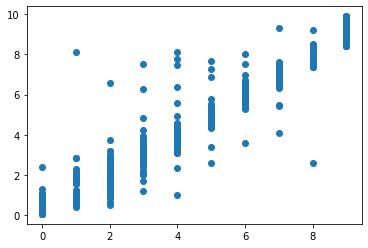

In [35]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  if(yy[i]<10):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

plt.scatter(yy_temp, predd_temp)

In [36]:
shuffled = df_reg2.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
X_modified = X

In [37]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
print(tmp.head(60))
tmp = tmp.sample(frac = 1).reset_index()
#y = np.log10(tmp['y']*10)+20
tmp = tmp.dropna()
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)

158574
158574
        n      k   av.length     std.dev     y
0   126.0  107.0  501.873016  128.004990  4510
1   198.0  175.0  780.762634  210.685165  4510
2   180.0  112.0  101.466667   50.076527  4510
3   162.0   73.0   57.500000   23.256935  1077
4   160.0   68.0   98.612503   18.766016  4510
5   220.0   79.0  100.040909   21.231562  4510
6   154.0   67.0  101.746750   19.346022  4510
7   144.0  121.0  373.298615  131.739197  4510
8   126.0  107.0  312.523804  109.223129  4510
9   100.0   56.0   99.040001   18.877554  1717
10  120.0   87.0   93.183334   47.574444  4510
11  120.0   87.0   93.183334   47.574444  4510
12  200.0  119.0  101.699997   49.112724  4510
13  162.0  136.0  399.481476  136.154510  4510
14  200.0  125.0  101.815002   50.574791  4510
15  108.0   89.0  442.814819  105.392731  4510
16  144.0  121.0  349.583344  125.159943  4510
17  198.0  172.0  508.691925  167.474625  4510
18  144.0  101.0   96.645836   45.839096  4510
19   80.0   68.0  326.762512   76.749016  4510

In [38]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 4510*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(12, activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(1, activation = custom_activation))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [39]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.83)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=30, batch_size=64, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


2057/2057 [==============================] - 4s 2ms/step - loss: 198029.0938
Epoch 2/30
2057/2057 [==============================] - 3s 2ms/step - loss: 103536.7812
Epoch 3/30
2057/2057 [==============================] - 3s 2ms/step - loss: 100356.9062
Epoch 4/30
2057/2057 [==============================] - 3s 2ms/step - loss: 98808.0859
Epoch 5/30
2057/2057 [==============================] - 3s 2ms/step - loss: 98107.7031
Epoch 6/30
2057/2057 [==============================] - 3s 2ms/step - loss: 98048.5703
Epoch 7/30
2057/2057 [==============================] - 3s 2ms/step - loss: 97325.3359
Epoch 8/30
2057/2057 [==============================] - 3s 2ms/step - loss: 97500.4453
Epoch 9/30
2057/2057 [==============================] - 3s 2ms/step - loss: 97171.5000
Epoch 10/30
2057/2057 [==============================] - 3s 2ms/step - loss: 96863.4609
Epoch 11/30
2057/2057 [==============================] - 3s 2ms/step - loss: 96478.9531
Epoch 12/30
2057/2057 [==========================

In [40]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

422/422 [==============================] - 1s 1ms/step
r_square score:  0.9275906641447448
RMSE:


306.21826909604675

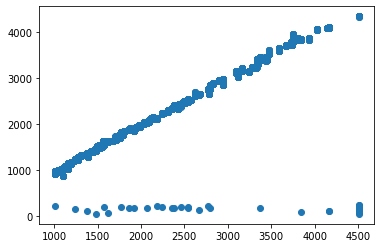

In [41]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  if(yy[i]>1000):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

plt.scatter(yy_temp, predd_temp)